In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('../data/feature_engineered_data.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nFIFA version distribution:")
print(df['fifa_version'].value_counts().sort_index())
print(f"\nTarget distribution:")
print(df['big_potential'].value_counts())

Dataset shape: (41458, 29)

FIFA version distribution:
fifa_version
17.0    8889
18.0    8814
19.0    8777
20.0    8091
21.0    6887
Name: count, dtype: int64

Target distribution:
big_potential
0    31162
1    10296
Name: count, dtype: int64


In [2]:
# Define temporal splits
train_versions = [17.0, 18.0, 19.0,20.0]

test_version = 21.0


df_train = df[df['fifa_version'].isin(train_versions)]

df_test = df[df['fifa_version'] == test_version]

print(f"Train (FIFA 17-20): {len(df_train)} samples")

print(f"Test (FIFA 21): {len(df_test)} samples")
print(df_train["big_potential"].value_counts())

Train (FIFA 17-20): 34571 samples
Test (FIFA 21): 6887 samples
big_potential
0    25968
1     8603
Name: count, dtype: int64


In [3]:

feature_columns = [col for col in df.columns if col not in ['fifa_version', 'big_potential']]
target = 'big_potential'

print(f"Number of features: {len(feature_columns)}")
print(f"Features: {feature_columns}")

# Prepare datasets
X_train = df_train[feature_columns]
y_train = df_train[target]
print(X_train.shape)
X_test = df_test[feature_columns]
y_test = df_test[target]
print(X_test.shape)

Number of features: 27
Features: ['age', 'physic', 'mentality_aggression', 'mentality_interceptions', 'power_stamina', 'power_strength', 'defending_marking_awareness', 'power_jumping', 'defending_standing_tackle', 'defending_sliding_tackle', 'attacking_heading_accuracy', 'mentality_composure', 'movement_reactions', 'skill_long_passing', 'skill_dribbling', 'skill_fk_accuracy', 'skill_ball_control', 'attacking_crossing', 'power_shot_power', 'attacking_finishing', 'skill_curve', 'movement_balance', 'attacking_volleys', 'power_long_shots', 'mentality_vision', 'mentality_penalties', 'movement_agility']
(34571, 27)
(6887, 27)


In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix
)

# Initialize Random Forest with balanced class weights for imbalanced data
rf_model = RandomForestClassifier(
    n_estimators=50,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features=0.3,
    class_weight='balanced',  # Handle class imbalance
    random_state=42,
    n_jobs=-1,
    verbose=0,
    bootstrap=True,
    criterion='gini'
)

print("Training Random Forest Classifier...")
rf_model.fit(X_train_scaled, y_train)
print("Training completed!")


Training Random Forest Classifier...
Training completed!


In [24]:
# Make predictions on test set
y_pred = rf_model.predict(X_test_scaled)
y_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("="*70)
print("RANDOM FOREST CLASSIFIER - Test Set (FIFA 21) Metrics")
print("="*70)
print(f"\nAccuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")

print("\n" + "-"*70)
print("Classification Report:")
print("-"*70)
print(classification_report(y_test, y_pred, target_names=['No Big Potential', 'Big Potential']))

print("-"*70)
print("Confusion Matrix:")
print("-"*70)
cm = confusion_matrix(y_test, y_pred)
print(f"                  Predicted")
print(f"                  No BP    BP")
print(f"Actual No BP     {cm[0,0]:5d}  {cm[0,1]:5d}")
print(f"Actual BP        {cm[1,0]:5d}  {cm[1,1]:5d}")


RANDOM FOREST CLASSIFIER - Test Set (FIFA 21) Metrics

Accuracy:  0.7025
Precision: 0.4305
Recall:    0.6509
F1 Score:  0.5182
ROC-AUC:   0.7526

----------------------------------------------------------------------
Classification Report:
----------------------------------------------------------------------
                  precision    recall  f1-score   support

No Big Potential       0.86      0.72      0.78      5194
   Big Potential       0.43      0.65      0.52      1693

        accuracy                           0.70      6887
       macro avg       0.65      0.69      0.65      6887
    weighted avg       0.76      0.70      0.72      6887

----------------------------------------------------------------------
Confusion Matrix:
----------------------------------------------------------------------
                  Predicted
                  No BP    BP
Actual No BP      3736   1458
Actual BP          591   1102


TOP 15 MOST IMPORTANT FEATURES
                    feature  importance
                        age    0.281053
         skill_ball_control    0.046327
                     physic    0.041728
       mentality_aggression    0.035889
    mentality_interceptions    0.030277
            skill_dribbling    0.030164
          attacking_volleys    0.029991
              power_jumping    0.029876
   defending_sliding_tackle    0.029861
              power_stamina    0.028690
 attacking_heading_accuracy    0.028517
  defending_standing_tackle    0.028249
        mentality_composure    0.028207
         movement_reactions    0.027832
defending_marking_awareness    0.027019


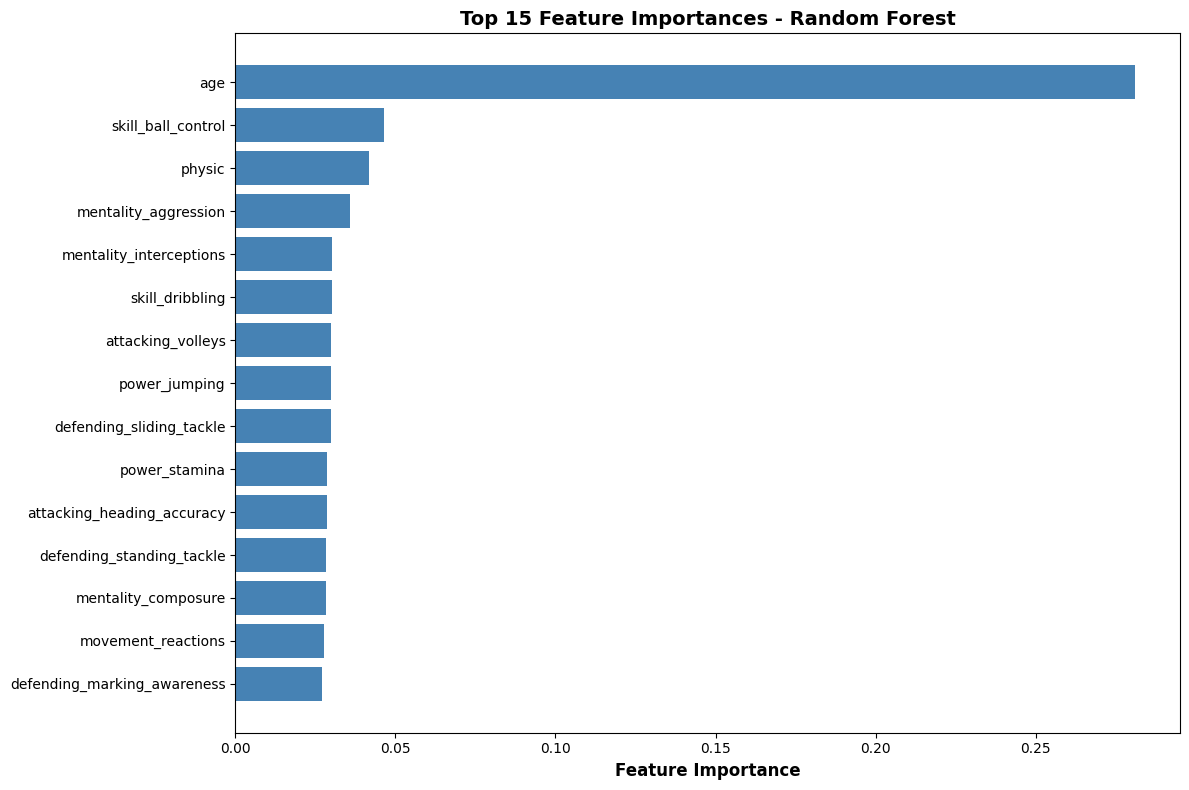

In [25]:
# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("="*70)
print("TOP 15 MOST IMPORTANT FEATURES")
print("="*70)
print(feature_importance.head(15).to_string(index=False))

# Visualize feature importance
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance', fontsize=12, fontweight='bold')
plt.title('Top 15 Feature Importances - Random Forest', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [26]:
y_train_pred = rf_model.predict(X_train_scaled)
y_train_proba = rf_model.predict_proba(X_train_scaled)[:, 1]

print("="*60)
print("BASELINE MODEL - Validation Set (FIFA 21) Metrics")
print(f"\nAccuracy:  {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Precision: {precision_score(y_train, y_train_pred):.4f}")
print(f"Recall:    {recall_score(y_train, y_train_pred):.4f}")
print(f"F1 Score:  {f1_score(y_train, y_train_pred):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_train, y_train_proba):.4f}")

print("\n" + "-"*60)
print("Classification Report:")
print("-"*60)
print(classification_report(y_train, y_train_pred, target_names=['No Big Potential', 'Big Potential']))

print("-"*60)

print(f"ROC-AUC:   {roc_auc_score(y_train, y_train_proba):.4f}")

print("\n" + "-"*60)
print("Classification Report:")
print("-"*60)
print(classification_report(y_train, y_train_pred, target_names=['No Big Potential', 'Big Potential']))

print("-"*60)
print("Confusion Matrix:")
print("-"*60)
cm = confusion_matrix(y_train, y_train_pred)
print(f"                  Predicted")
print(f"                  No BP    BP")
print(f"Actual No BP     {cm[0,0]:5d}  {cm[0,1]:5d}")
print(f"Actual BP        {cm[1,0]:5d}  {cm[1,1]:5d}")

BASELINE MODEL - Validation Set (FIFA 21) Metrics

Accuracy:  0.7711
Precision: 0.5266
Recall:    0.7929
F1 Score:  0.6329
ROC-AUC:   0.8648

------------------------------------------------------------
Classification Report:
------------------------------------------------------------
                  precision    recall  f1-score   support

No Big Potential       0.92      0.76      0.83     25968
   Big Potential       0.53      0.79      0.63      8603

        accuracy                           0.77     34571
       macro avg       0.72      0.78      0.73     34571
    weighted avg       0.82      0.77      0.78     34571

------------------------------------------------------------
ROC-AUC:   0.8648

------------------------------------------------------------
Classification Report:
------------------------------------------------------------
                  precision    recall  f1-score   support

No Big Potential       0.92      0.76      0.83     25968
   Big Potential    